In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import pyranges as pr
from scipy.stats import ks_2samp, epps_singleton_2samp
from statannotations.Annotator import Annotator

In [2]:
# Annotation
gtf = pr.read_gtf('../../data/genomes/GRCm38/gencode.vM22.primary_assembly.annotation.gtf', as_df=True)

In [3]:
gtf.head()

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,...,transcript_type,transcript_name,transcript_support_level,tag,havana_transcript,exon_number,exon_id,protein_id,ccdsid,ont
0,chr1,HAVANA,gene,3073252,3074322,.,+,.,ENSMUSG00000102693.1,TEC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,HAVANA,transcript,3073252,3074322,.,+,.,ENSMUSG00000102693.1,TEC,...,TEC,4933401J01Rik-201,NA,basic,OTTMUST00000127109.1,NaN,NaN,NaN,NaN,NaN
2,chr1,HAVANA,exon,3073252,3074322,.,+,.,ENSMUSG00000102693.1,TEC,...,TEC,4933401J01Rik-201,NA,basic,OTTMUST00000127109.1,1,ENSMUSE00001343744.1,NaN,NaN,NaN
3,chr1,ENSEMBL,gene,3102015,3102125,.,+,.,ENSMUSG00000064842.1,snRNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,ENSEMBL,transcript,3102015,3102125,.,+,.,ENSMUSG00000064842.1,snRNA,...,snRNA,Gm26206-201,NA,basic,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
ProteinCodingGenes = gtf.loc[(gtf.Feature == 'gene') & (gtf.gene_type == 'protein_coding'), 'gene_id'].values.tolist()

In [5]:
ProteinCodingGenes = [g.split('.')[0] for g in ProteinCodingGenes]

In [6]:
ProteinCodingGenes[:3]

['ENSMUSG00000051951', 'ENSMUSG00000025900', 'ENSMUSG00000025902']

In [7]:
# Import deseq2 results
df_KO_WT = pd.read_csv('res_S200WT_vs_KO_deseq_lfcShrink.csv', index_col=0).dropna(how='any')
df_KO_Mut = pd.read_csv('res_S200A_vs_KO_deseq_lfcShrink.csv', index_col=0).dropna(how='any')

# Import summed TPMs per gene
dfTPMCounts = pd.read_csv('TPMSum.csv', index_col=0)

# Import 3'UTRs
utrAtlas = pr.read_bed('../../data/3UtrAtlas/ThreePrimeUtrsOfMostExpressedTxInS200WT2iL.bed', as_df=True)

# Naive genes ids
DfNaive = pd.read_csv('../../data/general/NaiveGeneIds.csv', index_col=0)
# Extedned pluripotency gene ids
DfExdPluri = pd.read_csv('../../data/general/ExtendedPluripotencyGenesIds.csv', index_col=0)

# Import slamseq gene groups
slamseqGenes = pd.read_csv('../../data/DifferentialGeneGroups/RelevantGroupLociSlamseq_mm39/SlamseqFilteredAnnotated_mm39.bed', sep='\t', header=None)

In [8]:
# Set parameters
minUtrLen = 100

# Set outpath
outpath = '../../results/GeneGroups_Quantseq'
outpathUtr = '../../results/GeneGroups_Quantseq/3UtrLoci/'
os.makedirs(outpath, exist_ok=True)
os.makedirs(outpathUtr, exist_ok=True)

In [9]:
df_KO_WT.head()

,baseMean,log2FoldChange,lfcSE,pvalue,padj
LIN28A_transgene,3627.405746,11.973142,0.766634,4.173808e-56,5.684308e-52
ENSMUSG00000046733,470.707254,4.880912,0.388856,1.673983e-37,1.139898e-33
ENSMUSG00000022037,141.343956,3.445942,0.279422,5.038324e-36,2.287231e-32
ENSMUSG00000024349,113.983796,4.369500,0.366371,4.300169e-34,1.464100e-30
ENSMUSG00000031785,258.278694,8.463244,0.717163,4.908110e-33,1.336871e-29


In [10]:
# Remove genes that are not protein-coding
df_KO_WT = df_KO_WT.loc[[i for i in df_KO_WT.index if i in ProteinCodingGenes]]
df_KO_Mut = df_KO_Mut.loc[[i for i in df_KO_Mut.index if i in ProteinCodingGenes]]

In [11]:
def GetSignificant(df, pval=0.05, FC=1.5, Unchanged=0.5):
    df.loc[df.padj < pval, 'significance'] = 'significant'
    df.loc[(df.log2FoldChange > np.log2(FC)) & (df.significance == 'significant'), 'regulation'] = 'UP'
    df.loc[(df.log2FoldChange < -np.log2(FC)) & (df.significance == 'significant'), 'regulation'] = 'DOWN'
    df.loc[(df.log2FoldChange > -Unchanged) & (df.log2FoldChange < Unchanged) & (df.significance != 'significant'), 'regulation'] = 'CONTROL'
    return df

In [12]:
GetSignificant(df_KO_Mut).groupby('regulation').count()

,baseMean,log2FoldChange,lfcSE,pvalue,padj,significance
regulation,,,,,,
CONTROL,11497,11497,11497,11497,11497,0
DOWN,66,66,66,66,66,66
UP,303,303,303,303,303,303


In [13]:
GetSignificant(df_KO_WT).groupby('regulation').count()

,baseMean,log2FoldChange,lfcSE,pvalue,padj,significance
regulation,,,,,,
CONTROL,5896,5896,5896,5896,5896,0
DOWN,1755,1755,1755,1755,1755,1755
UP,2077,2077,2077,2077,2077,2077


In [14]:
# Sort genes into three groups
df_KO_WT_grouped = GetSignificant(df_KO_WT)                                                                                                                                                                                                                                                                                           
df_KO_WT_grouped = df_KO_WT_grouped.loc[df_KO_WT_grouped.regulation != np.nan].sort_values(by='log2FoldChange')
df_KO_WT_grouped['significance'].fillna('not significant', inplace=True)


df_KO_Mut_grouped = GetSignificant(df_KO_Mut)
df_KO_Mut_grouped = df_KO_Mut_grouped.loc[df_KO_Mut_grouped.regulation != np.nan].sort_values(by='log2FoldChange')
df_KO_Mut_grouped['significance'].fillna('not significant', inplace=True)

# Add information about naive genes and extended pluripotency genes
# extended pluripotency
df_KO_WT_grouped.loc[[i for i in DfExdPluri.gene_id.values.tolist() if i in df_KO_WT_grouped.index], 'Naive_Genes'] = 'extended_pluripotency'
df_KO_Mut_grouped.loc[[i for i in DfExdPluri.gene_id.values.tolist() if i in df_KO_Mut_grouped.index], 'Naive_Genes'] = 'extended_pluripotency'
# naive
df_KO_WT_grouped.loc[DfNaive.gene_id.values.tolist(), 'Naive_Genes'] = 'naive'
df_KO_Mut_grouped.loc[DfNaive.gene_id.values.tolist(), 'Naive_Genes'] = 'naive'

# Add UTR lengths to genes
utrAtlas.rename(columns={'ThickStart': 'gene_name', 'ThickEnd': 'transcript_id'}, inplace=True)
utrAtlas['length'] = utrAtlas.End - utrAtlas.Start
UtrLengths = utrAtlas.set_index('Name')
df_KO_WT_grouped['UtrLength'] = UtrLengths['length'].astype(int)
df_KO_Mut_grouped['UtrLength'] = UtrLengths['length'].astype(int)

# Save
df_KO_WT_grouped.to_csv(f'{outpath}/KO_WT_GeneGroups_NoTPMRangeAdjustment.csv')
df_KO_Mut_grouped.to_csv(f'{outpath}/KO_S200A_GeneGroups_NoTPMRangeAdjustment.csv')

In [15]:
df_KO_WT_grouped.sort_values(by='log2FoldChange').head()

,baseMean,log2FoldChange,lfcSE,pvalue,padj,significance,regulation,Naive_Genes,UtrLength
ENSMUSG00000019989,100.502042,-6.899289,1.187185,2.130376e-12,2.844469e-10,significant,DOWN,NaN,1499.0
ENSMUSG00000054727,33.385117,-6.442636,2.680247,1.643360e-05,2.451360e-04,significant,DOWN,NaN,268.0
ENSMUSG00000067261,66.277230,-5.905145,1.336072,1.958259e-08,8.658938e-07,significant,DOWN,naive,591.0
ENSMUSG00000048070,19.045768,-5.806832,2.558161,5.910746e-05,6.957515e-04,significant,DOWN,NaN,3607.0
ENSMUSG00000025056,404.741559,-5.527831,1.179622,1.667853e-07,5.209746e-06,significant,DOWN,NaN,355.0


In [16]:
# Sox2
df_KO_WT_grouped.loc['ENSMUSG00000074637']

baseMean              2467.878746
log2FoldChange          -0.069939
lfcSE                    0.240607
pvalue                   0.752282
padj                     0.832006
significance      not significant
regulation                CONTROL
Naive_Genes                 naive
UtrLength                  1089.0
Name: ENSMUSG00000074637, dtype: object

In [17]:
# Klf4 - first lfc cutoff of 1 was too stringent, but otherwise downregulated
df_KO_WT_grouped.loc['ENSMUSG00000003032']

baseMean          2169.870209
log2FoldChange      -0.957643
lfcSE                 0.35902
pvalue               0.002299
padj                 0.011915
significance      significant
regulation               DOWN
Naive_Genes             naive
UtrLength               985.0
Name: ENSMUSG00000003032, dtype: object

In [18]:
# Nanog is in DOWN
df_KO_WT_grouped.loc['ENSMUSG00000012396']

baseMean           735.328231
log2FoldChange      -2.677617
lfcSE                0.526309
pvalue                    0.0
padj                 0.000001
significance      significant
regulation               DOWN
Naive_Genes             naive
UtrLength              1081.0
Name: ENSMUSG00000012396, dtype: object

In [19]:
# Esrrb - first lfc cutoff of 1 was too stringent, but otherwise downregulated
df_KO_WT_grouped.loc['ENSMUSG00000021255']

baseMean          1021.670024
log2FoldChange      -0.997053
lfcSE                0.249144
pvalue               0.000024
padj                  0.00033
significance      significant
regulation               DOWN
Naive_Genes             naive
UtrLength              2566.0
Name: ENSMUSG00000021255, dtype: object

## Crossreference with slamseq genes

In [20]:
# Check how many genes from slamseq crossvalidate with quantseq groups
slamseqGenes = slamseqGenes[[3, 6]]
slamseqGenes.columns = ['regulation', 'annotation']
slamseqGenes['gene_id'] = slamseqGenes.annotation.apply(lambda x: x.split('_')[-1])

In [21]:
slamseqGenes.regulation = slamseqGenes.regulation.apply(lambda x: x.split('-')[0])

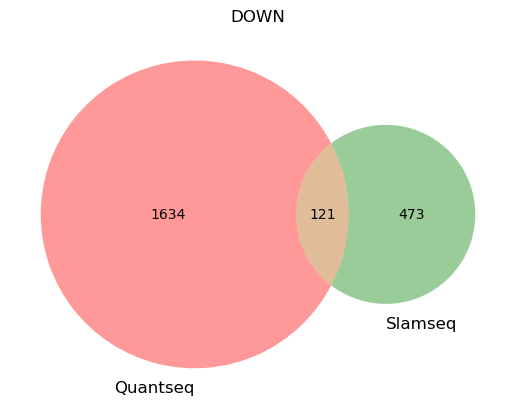

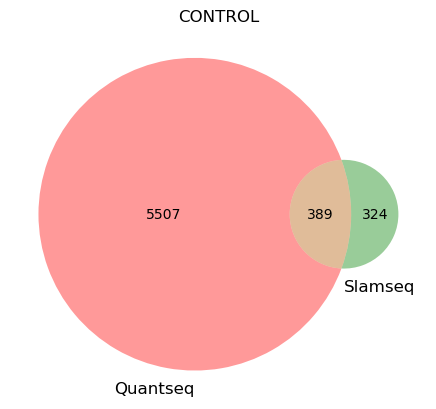

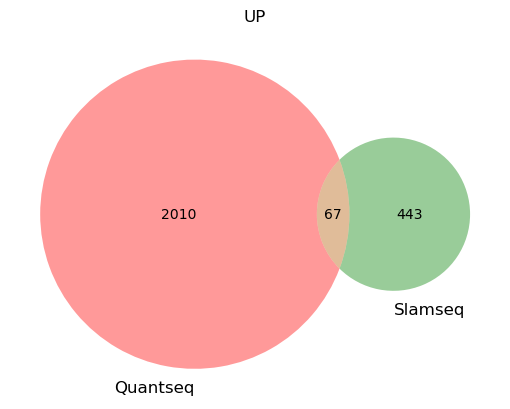

In [22]:
for g in slamseqGenes.regulation.unique():
    slam = sorted(set(slamseqGenes.loc[slamseqGenes.regulation == g, 'gene_id'].values.tolist()))
    quant = sorted(set(df_KO_WT_grouped.loc[df_KO_WT_grouped.regulation == g].index.tolist()))
    common = [g for g in slam if g in quant]
    slam_un = len(slam) - len(common)
    quant_un = len(quant) - len(common)
    venn2(subsets=(quant_un, slam_un, len(common)), set_labels=('Quantseq', 'Slamseq'))
    plt.title(g)
    plt.show()

## Compare expression levels in unfiltered groups

In [23]:
dfTPMCounts.head()

,KO_E12_FCL_1,KO_E12_FCL_2,KO_E12_FCL_3,S200A_3_FCL_1,S200A_3_FCL_2,S200A_3_FCL_3,S200A_5_FCL_1,S200A_5_FCL_2,S200WT_1_FCL_1,S200WT_1_FCL_2,S200WT_2_FCL_3
stable_gene_id,,,,,,,,,,,
ENSMUSG00000000001,6.530924,9.363520,5.442524,2.005899,2.375329,8.920072,2.403916,9.464212,0.307615,2.139486,2.946704
ENSMUSG00000000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000000028,7.710276,9.091545,7.334555,3.027887,5.469507,9.357579,4.251148,8.563081,2.505082,3.344192,4.119250
ENSMUSG00000000031,0.000000,0.000000,0.000000,1.556927,0.583990,0.706341,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000000037,0.016093,0.057227,0.041397,0.237239,0.064356,0.163073,0.117013,0.108123,0.454818,0.096248,0.196450


In [24]:
# Compare expression levels between three groups in KO FCL condition
df_KO_WT_grouped['Mean TPM in KO FCL'] = dfTPMCounts[[c for c in dfTPMCounts.columns if 'KO_' in c]].mean(axis='columns')
df_KO_WT_grouped['Mean TPM in S200WT FCL'] = dfTPMCounts[[c for c in dfTPMCounts.columns if 'S200WT_' in c]].mean(axis='columns')

In [25]:
df_KO_WT_grouped.head()

,baseMean,log2FoldChange,lfcSE,pvalue,padj,significance,regulation,Naive_Genes,UtrLength,Mean TPM in KO FCL,Mean TPM in S200WT FCL
ENSMUSG00000019989,100.502042,-6.899289,1.187185,2.130376e-12,2.844469e-10,significant,DOWN,NaN,1499.0,6.805262,0.029012
ENSMUSG00000054727,33.385117,-6.442636,2.680247,1.643360e-05,2.451360e-04,significant,DOWN,NaN,268.0,1.449495,0.000000
ENSMUSG00000067261,66.277230,-5.905145,1.336072,1.958259e-08,8.658938e-07,significant,DOWN,naive,591.0,16.837129,0.368562
ENSMUSG00000048070,19.045768,-5.806832,2.558161,5.910746e-05,6.957515e-04,significant,DOWN,NaN,3607.0,0.345442,0.000000
ENSMUSG00000025056,404.741559,-5.527831,1.179622,1.667853e-07,5.209746e-06,significant,DOWN,NaN,355.0,92.916880,1.507541


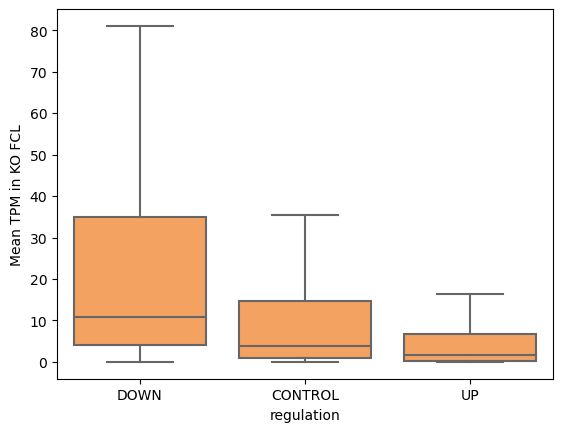

In [26]:
# No TPM-based filtering - KO_FCL
g = sns.boxplot(data=df_KO_WT_grouped, x='regulation', y='Mean TPM in KO FCL', showfliers=False,  color='#f4a261', saturation=1)
g.figure.savefig(f'{outpath}/KO_FCL_TpmRangesForAllGroupedGenes.pdf', bbox_inches='tight')

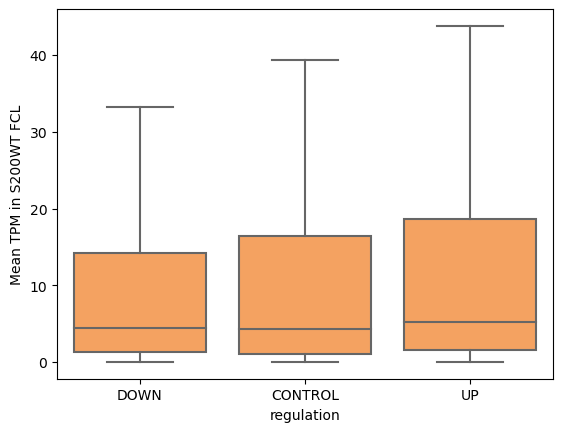

In [27]:
# No TPM-based filtering - S200WT_FCL
g = sns.boxplot(data=df_KO_WT_grouped, x='regulation', y='Mean TPM in S200WT FCL', showfliers=False,  color='#f4a261', saturation=1)
g.figure.savefig(f'{outpath}/S200WT_FCL_TpmRangesForAllGroupedGenes.pdf', bbox_inches='tight')

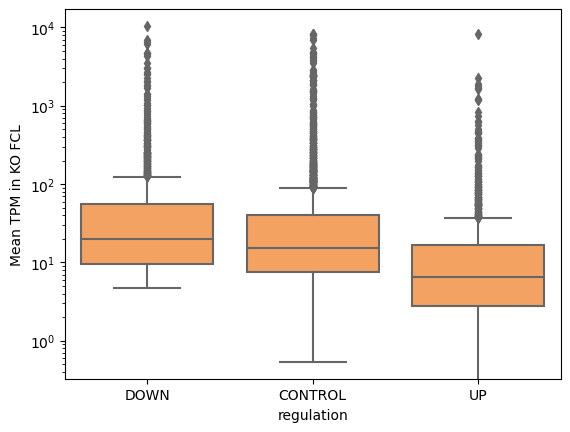

In [28]:
# Applying a min TPM filter of 5 in KO_FCL or WT_FCL
g = sns.boxplot(
    data=df_KO_WT_grouped.loc[(df_KO_WT_grouped['Mean TPM in KO FCL'] >= 5) | (df_KO_WT_grouped['Mean TPM in S200WT FCL'] >= 5)], \
    x='regulation', y='Mean TPM in KO FCL', showfliers=True, color='#f4a261', saturation=1
    )
g.set_yscale('log')
plt.show()
g.figure.savefig(f'{outpath}/TpmRangesForGenesWithMeanTpmInKoFCLOrWtFclAbove5.pdf', bbox_inches='tight')


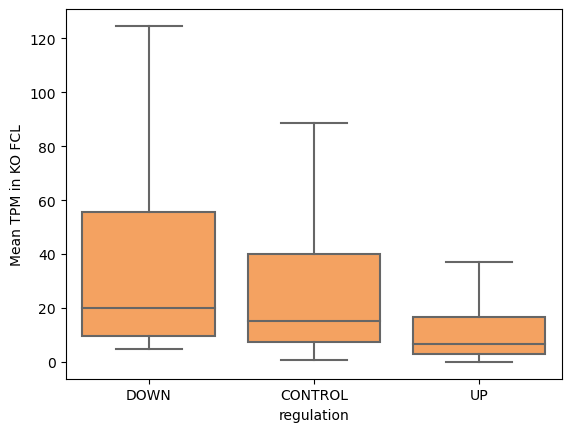

In [31]:
# Applying a min TPM filter of 5 in KO_FCL or WT_FCL
g = sns.boxplot(
    data=df_KO_WT_grouped.loc[(df_KO_WT_grouped['Mean TPM in KO FCL'] >= 5) | (df_KO_WT_grouped['Mean TPM in S200WT FCL'] >= 5)], \
    x='regulation', y='Mean TPM in KO FCL', showfliers=False, color='#f4a261', saturation=1
    )
g.figure.savefig(f'{outpath}/TpmRangesForGenesWithMeanTpmInKoFCLOrWtFclAbove5_nofliers.pdf', bbox_inches='tight')

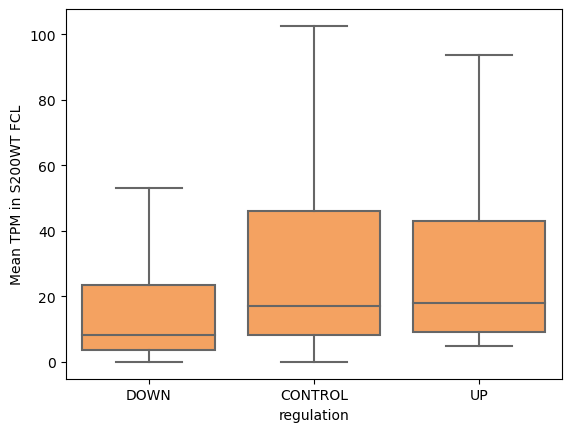

In [34]:
# Applying a min TPM filter of 5 in KO_FCL or WT_FCL
g = sns.boxplot(
    data=df_KO_WT_grouped.loc[(df_KO_WT_grouped['Mean TPM in KO FCL'] >= 5) | (df_KO_WT_grouped['Mean TPM in S200WT FCL'] >= 5)], \
    x='regulation', y='Mean TPM in S200WT FCL', showfliers=False, color='#f4a261', saturation=1
    )
g.figure.savefig(f'{outpath}/TpmRangesForGenesWithMeanTpmInKoFCLOrWtFclAbove5_nofliers.pdf', bbox_inches='tight')

In [29]:
# Remove lowly expressed genes (excluding naive genes)
df_KO_WT_grouped = df_KO_WT_grouped.loc[(df_KO_WT_grouped.Naive_Genes == 'naive') | \
                                        (df_KO_WT_grouped['Mean TPM in KO FCL'] >= 5) | \
                                        (df_KO_WT_grouped['Mean TPM in S200WT FCL'] >= 5)]

df_KO_WT_grouped.to_csv(f'{outpath}/KO_WT_GeneGroups_TPMGreaterThan5InEitherCondition_NaiveExemption_NoUtrLengthFilter.csv')

In [30]:
# How many genes remain after filtering?
df_KO_WT_grouped.groupby('regulation').count()['baseMean']

regulation
CONTROL    2891
DOWN       1240
UP         1062
Name: baseMean, dtype: int64

## Compare Utr lengths

DOWN vs. CONTROL: Welch's t-test independent samples, P_val:9.576e-01 t=5.313e-02
DOWN vs. UP: Welch's t-test independent samples, P_val:5.538e-01 t=-5.922e-01


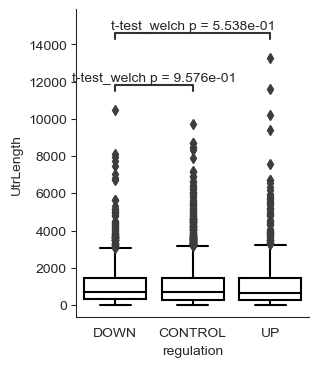

In [68]:
# Prior to filtering
sns.set_style('white')
dfPlot = df_KO_WT_grouped.loc[df_KO_WT_grouped.UtrLength > 0]

PROPS = {
    'boxprops':{'facecolor':'white', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}

fig, ax = plt.subplots(figsize=(3, 4))
g = sns.boxplot(
    data = dfPlot, x='regulation', y='UtrLength', order=["DOWN", "CONTROL", "UP"],
    showfliers=True, **PROPS, ax=ax)
g.tick_params(left=True)
# g.set_yscale('log')
sns.despine(top=True, right=True)

annot = Annotator(g, pairs=[("DOWN", "CONTROL"), ("DOWN", "UP")],\
                data=dfPlot, x="regulation", y="UtrLength", order=["DOWN", "CONTROL", "UP"])
annot.configure(test='t-test_welch', text_format='full', loc='inside', verbose=2)
annot.apply_test().annotate()
fig.savefig('Boxplot_UtrLengts.pdf', bbox_inches='tight')


In [39]:
# Check 3'UTR lengths in naive genes
df_KO_WT_grouped.loc[df_KO_WT_grouped.Naive_Genes == 'naive', 'UtrLength'].sort_values()
# One naive gene will be filtered out based on UTR length (ENSMUSG00000009733).

ENSMUSG00000009733      47.0
ENSMUSG00000038773     524.0
ENSMUSG00000051176     532.0
ENSMUSG00000067261     591.0
ENSMUSG00000061524     612.0
ENSMUSG00000053470     666.0
ENSMUSG00000055148     740.0
ENSMUSG00000042414     806.0
ENSMUSG00000041359     952.0
ENSMUSG00000055799     985.0
ENSMUSG00000003032     985.0
ENSMUSG00000012396    1081.0
ENSMUSG00000074637    1089.0
ENSMUSG00000031665    1146.0
ENSMUSG00000018604    1635.0
ENSMUSG00000005148    1710.0
ENSMUSG00000067860    2013.0
ENSMUSG00000041483    2089.0
ENSMUSG00000021255    2566.0
ENSMUSG00000026398    2895.0
ENSMUSG00000040943    3061.0
ENSMUSG00000033863    3225.0
ENSMUSG00000026380    7737.0
Name: UtrLength, dtype: float64

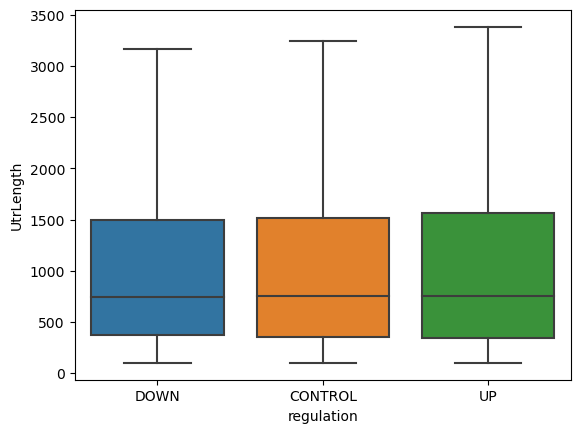

In [40]:
# Filter out genes with 3'UTRs shorter than 100
df_KO_WT_grouped = df_KO_WT_grouped.loc[df_KO_WT_grouped.UtrLength >= minUtrLen]
# Post filtering
g = sns.boxplot(data = df_KO_WT_grouped, x='regulation', y='UtrLength', showfliers=False)

In [41]:
# How many genes are left in each group now?
df_KO_WT_grouped.groupby('regulation').count()['baseMean']

regulation
CONTROL    2703
DOWN       1183
UP          989
Name: baseMean, dtype: int64

In [42]:
df_KO_WT_grouped.to_csv(f'{outpath}/KO_WT_GeneGroups_TPMGreaterThan5InEitherCondition_NaiveExemption_MinUtrLen{minUtrLen}.csv')